# Optical Flow using Lucas Kanade Method
### Assignment 5 
#### Himansh Sheoran 20161211

In this assignment our goal is to apply optical flow for tracking objects in a moving scene 

The method works by finding movement of pixels in the 2 frames. Here we find the least square solution on a vector using the gradient in the x&y direaction to predicts the movement of the pixels 

We are given the a dataset containg 2 & 8 frames. 


In [1]:
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sys
import scipy
from scipy import signal
import numpy as np
import random
import math
import os


## Lucas Kanade

**About:** The method assumes that the flow is essentially constant in a local neighbourhood of the pixel under consideration, and solves the basic optical flow equations for all the pixels in that neighbourhood, by the least squares criterion.

By combining information from several nearby pixels, the Lucas–Kanade method can often resolve the inherent ambiguity of the optical flow equation. It is also less sensitive to image noise than point-wise methods. On the other hand, since it is a purely local method, it cannot provide flow information in the interior of uniform regions of the image, however can be optimized once the region is defined.

**Implemetation: ** 

The Lucas–Kanade method assumes that the displacement of the image contents between two nearby instants (frames) is small and approximately constant within a neighborhood of the point p under consideration. Thus the optical flow equation can  be assumed to be holding true in  a certain window size w. Assuming the points to be moved by Vx and Vy in the directions so we can assume that the change is very slight from where we can derive the equations a following:

    I x ( q 1 ) V x + I y ( q 1 ) V y = − I t ( q 1 )

    I x ( q 2 ) V x + I y ( q 2 ) V y = − I t ( q 2 ) 
    .......
    .......
    .......
    I x ( q n ) V x + I y ( q n ) V y = − I t ( q n )
    
    where q 1 , q 2 , … , q n are the pixels inside the window
  So the equations can be represented as  a matrix where
   ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/4dba1d119546e8fe15ad701c99d0e32595f9a6c8)
    
    The problem can be now mapped to least square error as learnt in optimisation methods.
    
    So we can take the partial inverse and get equations like
   ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/c0243b8dc5b55074c9a3a6c623970a60fbc13f86)
   
   The code implemented follows the steps as mentioned above

In [2]:
def display_opticalflow_results(im1,im2,u,v,fig_size=(16,16),arrow_thres=0.02):    
    fig = plt.figure(figsize=fig_size)
    
    #     Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Image T:1")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Image T:2")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='gray')
    ax.set_title("V")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(u*u + v*v,cmap='gray')
    ax.set_title("U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='gray')
    ax.set_title("arc(v/u)")
    ax.axis('off')

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Optical flow Arrows")
    kp = cv2.goodFeaturesToTrack(im1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,u[y,x],v[y,x],head_width = 1, head_length = 5, color = (0,1,0))
        
    ax = fig.add_subplot(1,2,2)
    ax.imshow( (u*u + v*v>arrow_thres),cmap='gray')
    ax.set_title("Optical flow Mask")
    
    ax.axis('off')
   

    plt.show()

In [3]:
def optical_flow(img1, img2, window_size):
    tau=1e-2
    mode = 'same'
    x_kernel = np.array([[-1., 1.], [-1., 1.]])
    y_kernel = np.array([[-1., -1.], [1., 1.]])
    t_kernel = np.array([[1., 1.], [1., 1.]])
    w = window_size//2
    img1 = img1 / 255. 
    img2 = img2 / 255. 
    gradx = signal.convolve2d(img1, x_kernel, boundary='symm', mode=mode)
    grady = signal.convolve2d(img1, y_kernel, boundary='symm', mode=mode)
    gradt = signal.convolve2d(img2, t_kernel, boundary='symm', mode=mode) + signal.convolve2d(img1, -t_kernel, boundary='symm', mode=mode)
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    row = img1.shape[0]
    col = img1.shape[1]
    for i in range(w, row-w):
        for j in range(w, col-w):
            start1 = i-w 
            end1 = i+w+1
            start2 = j-w
            end2 = j+w+1
            Ix = gradx[start1:end1, start2:end2].flatten()
            Iy = grady[start1:end1, start2:end2].flatten()
            It = gradt[start1:end1, start2:end2].flatten()
            sumxx = np.sum(Ix*Ix)
            sumxy = np.sum(Ix*Iy)
            sumyy = np.sum(Iy*Iy)
            sumxt = np.sum(Ix*It)
            sumyt = np.sum(Iy*It)
            A = [ [ sumxx,sumxy], [sumxy, sumyy] ]
            A = np.array(A)
            b = [-sumxt, -sumyt]
            b = np.array(b)
            temp = A.T.dot(A)
            U,D,V_T = np.linalg.svd(temp)
            
            if np.min(D) >= tau:    
                try:
                    nu = np.linalg.inv(A).dot(b)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(A,D,e)
            
            else:
                u[i,j]=0
                v[i,j]=0                
                
    return [u,v]

### Segmentation Using Optical Flow

For this part I have taken refernece from [this](https://arxiv.org/pdf/1807.04890.pdf) publication.

We define
**pt** as the set of points in the window

**Ft,Ft−k=Ht→Ft−k∗pt−pt**

In [7]:
def segmentation_as_time(im1,im2,threshold,iter =5):
    orb = cv2.ORB_create(500)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches.sort(key=lambda x: x.distance, reverse=False)
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
    width = im1.shape[1]
    height = im1.shape[0]
    im2Reg = cv2.warpPerspective(im2, h, (width, height))
    im3 = im2Reg - im2    

    im4 = np.zeros(im2.shape)
    for i in range(im3.shape[0]):
        for j in range(im3.shape[1]):
            im4[i,j] = abs(math.cos(im2[i,j]-im3[i,j]))

    t = threshold

    for i in range(im4.shape[0]):
        for j in range(im4.shape[1]):
            if im4[i,j] < t:
                im4[i,j] = 1
            else:
                im4[i,j] = 0


    kernel = np.ones((4,4),np.uint8)
    im4 = cv2.dilate(im4,kernel,iterations = iter)
    plt.figure()
    plt.imshow(im4,cmap = 'gray')
    plt.show()


In [8]:
img_dir ='./eval-data-gray/'
img_pair_list = []
for dirname in sorted(os.listdir(img_dir)):
    if os.path.isdir(os.path.join(img_dir,dirname)):
        im1_path,im2_path = os.listdir(os.path.join(img_dir,dirname))
        im1 = cv2.imread(os.path.join(img_dir,dirname,im1_path),0)
        im2 = cv2.imread(os.path.join(img_dir,dirname,im2_path),0)
        img_pair_list.append([im1,im2])

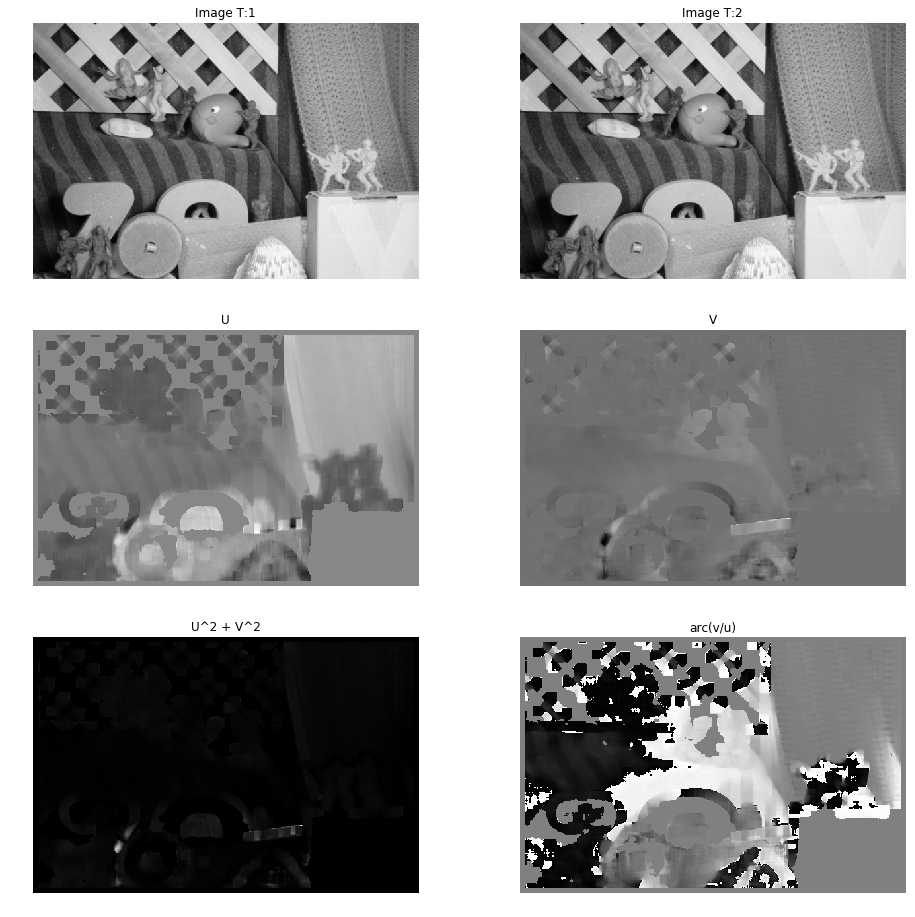

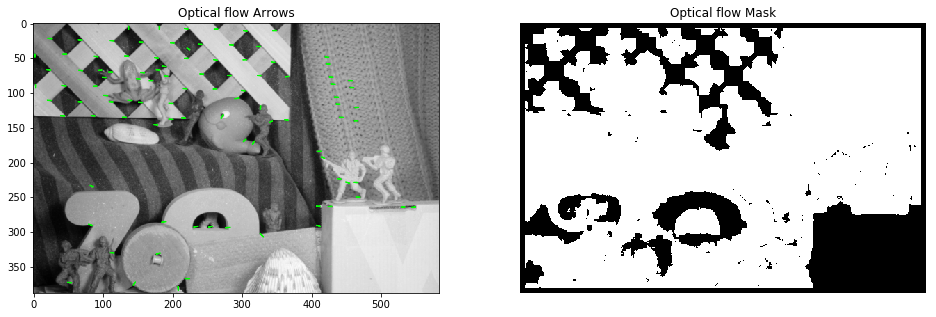

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


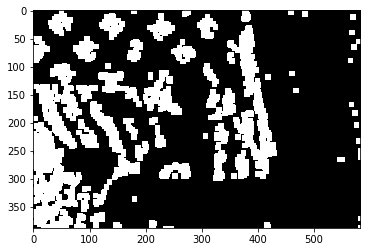

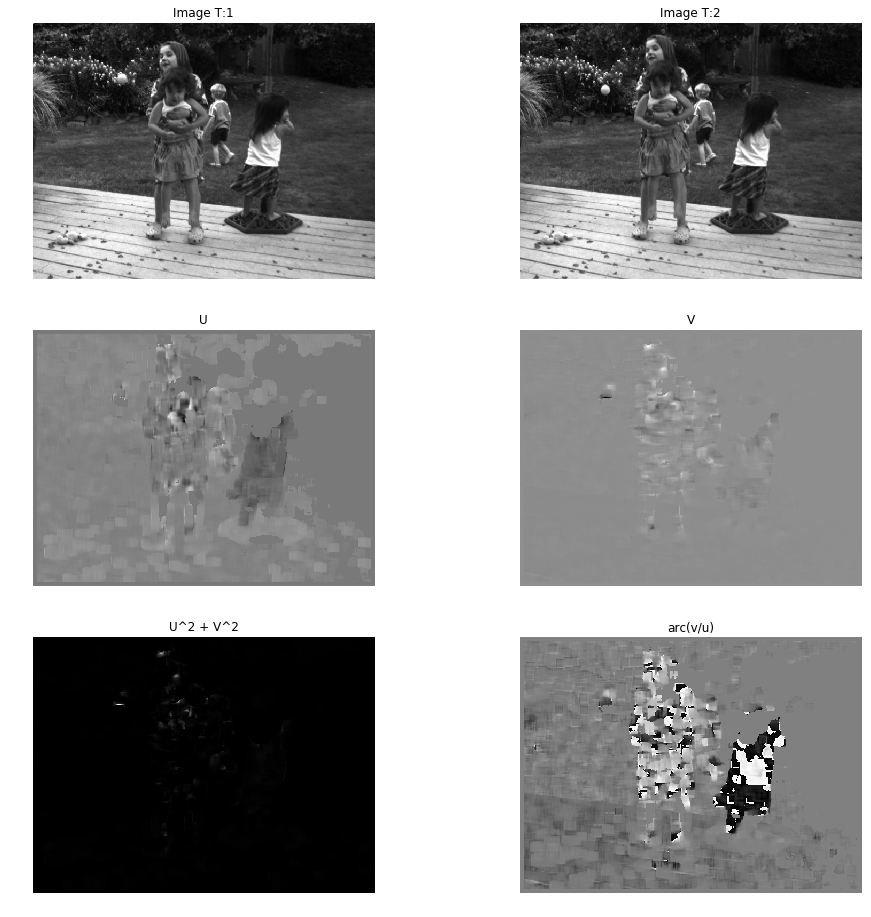

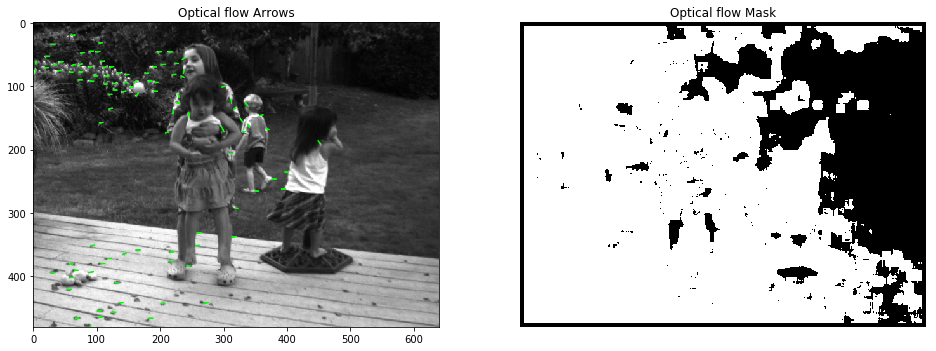

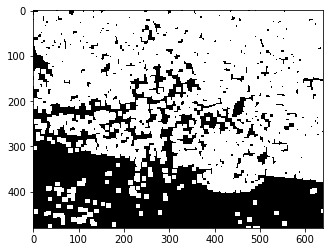

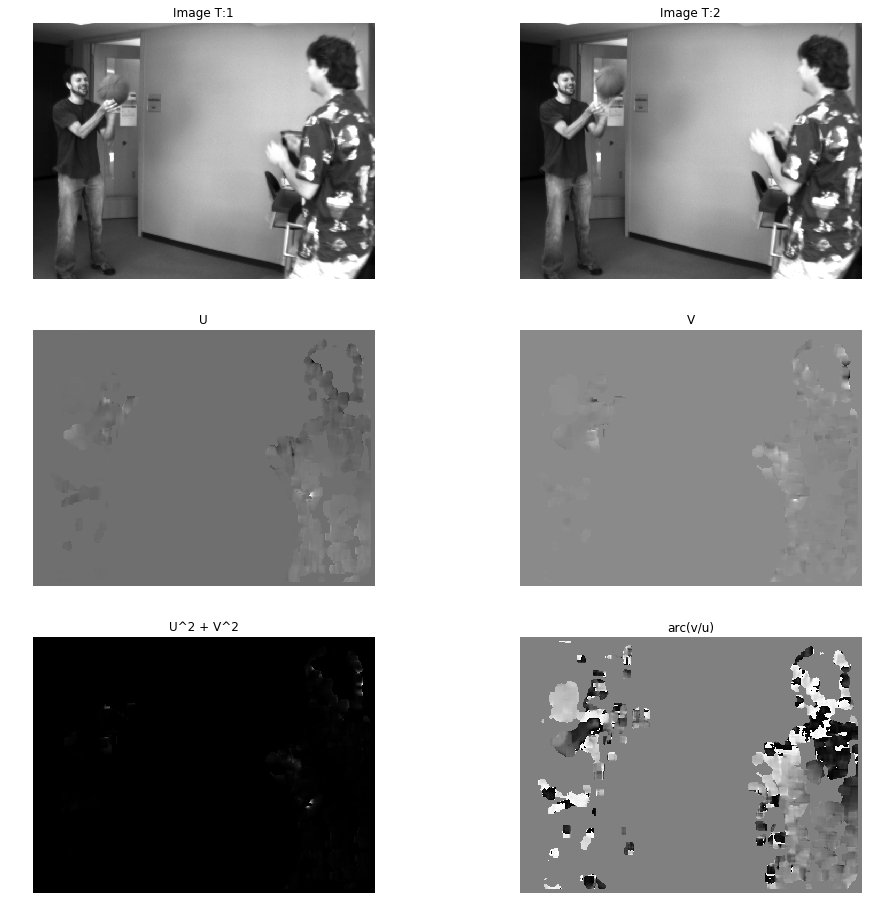

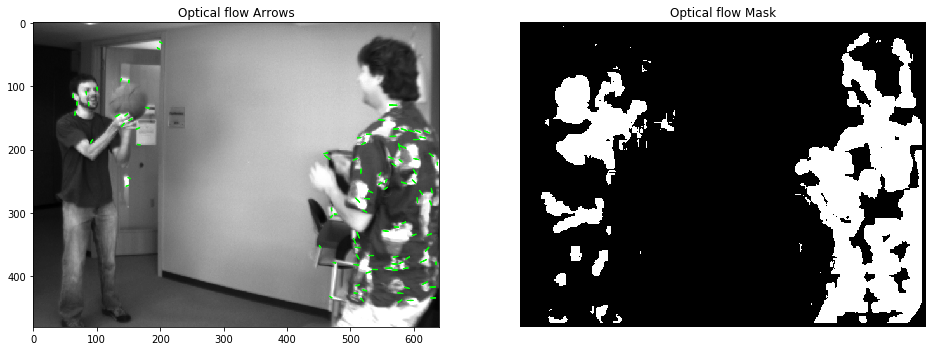

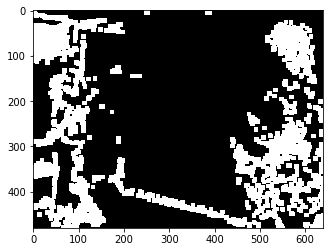

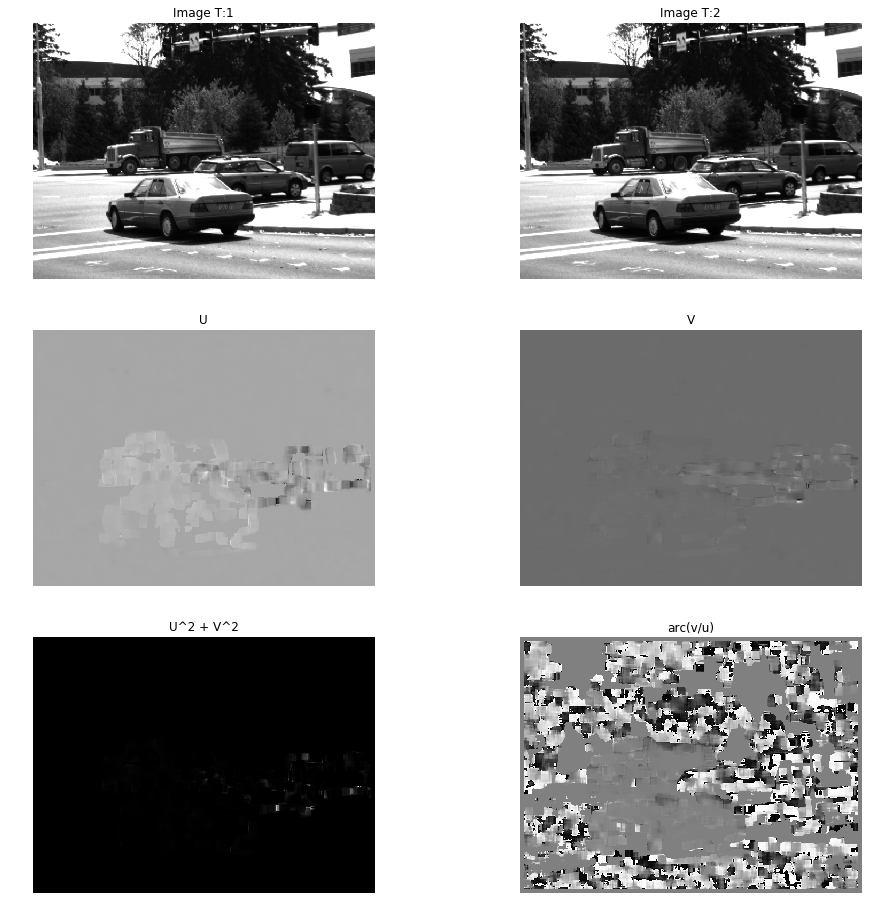

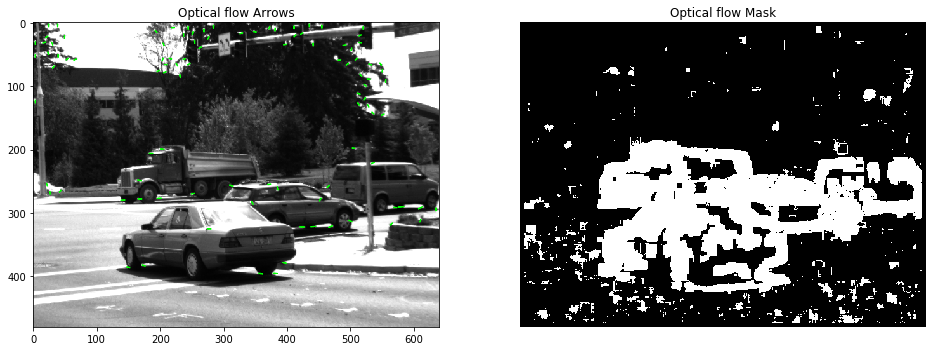

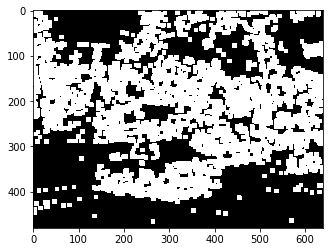

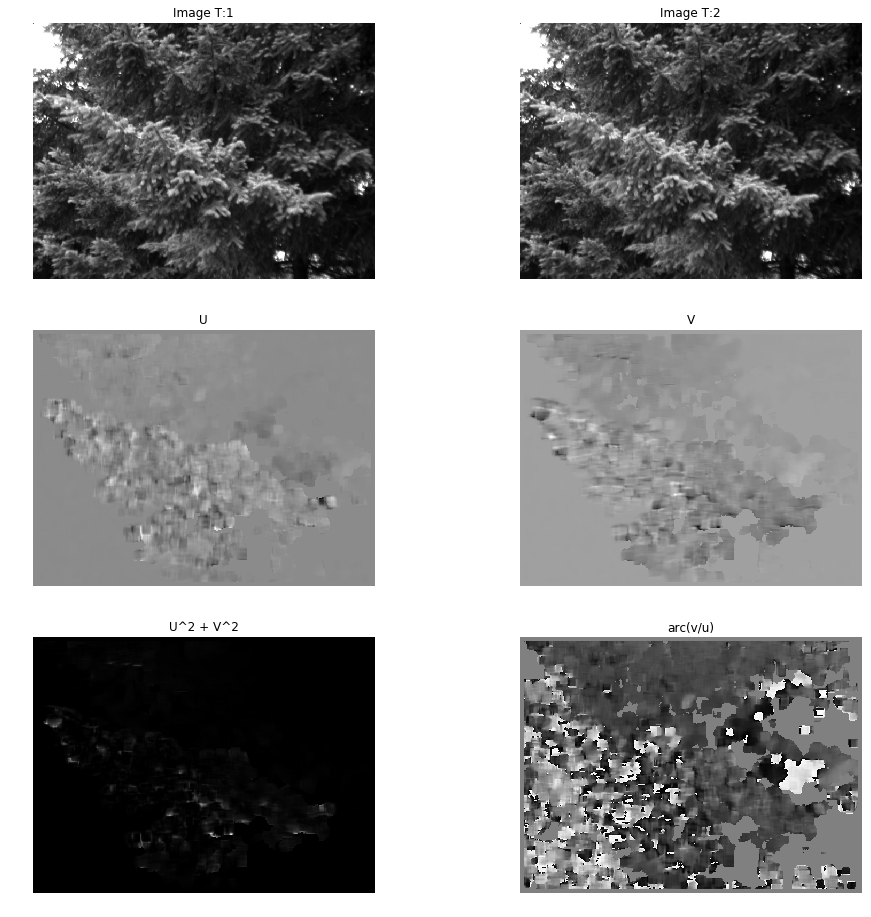

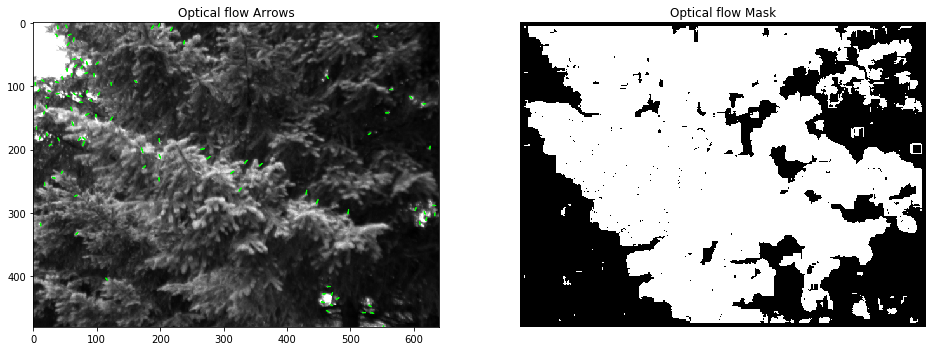

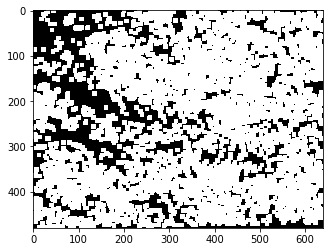

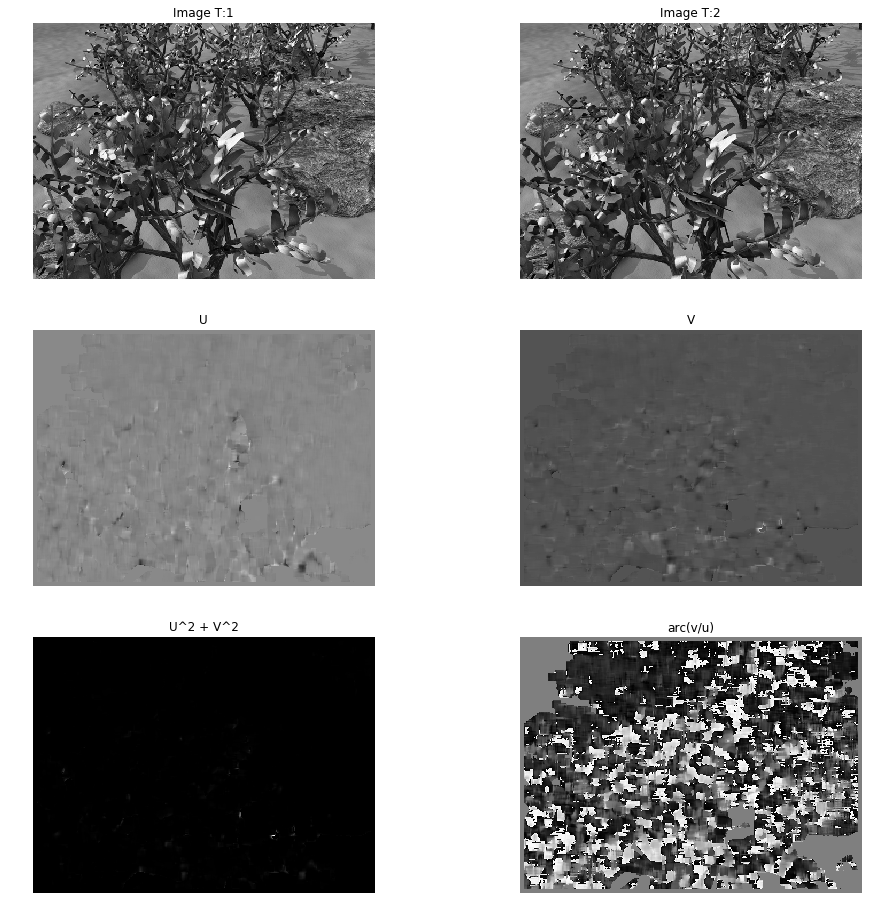

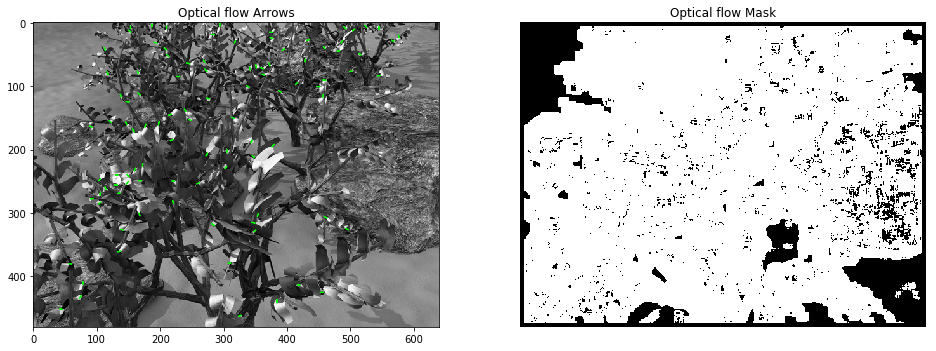

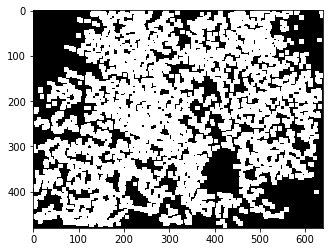

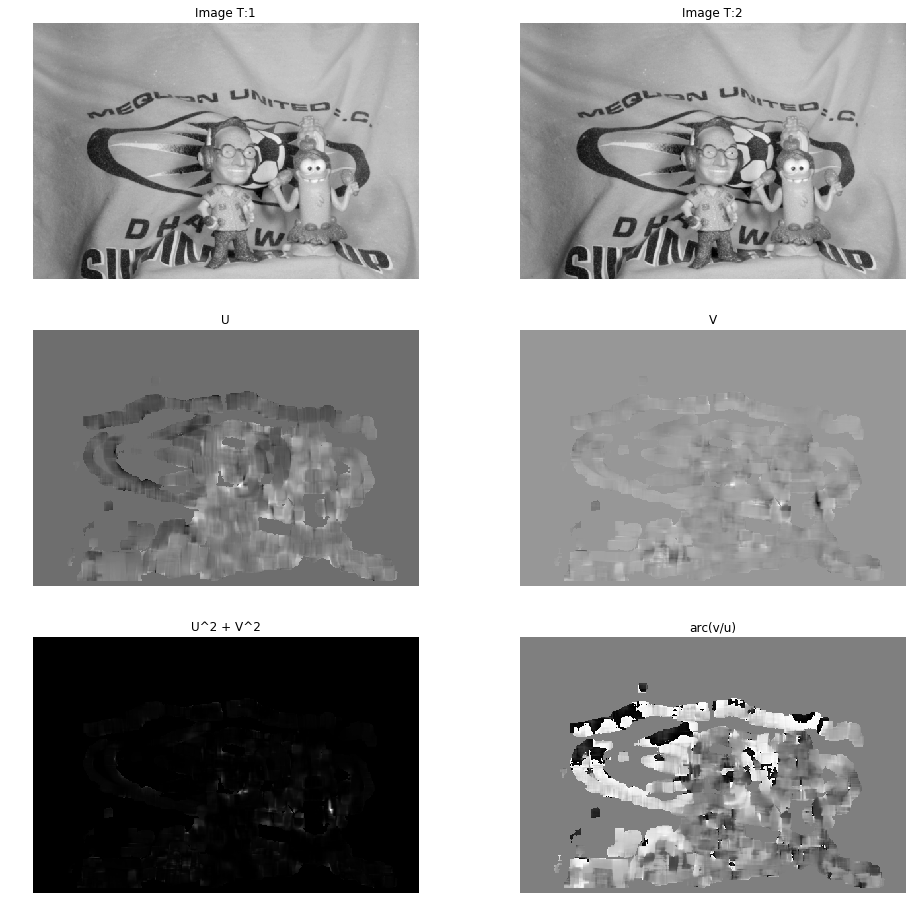

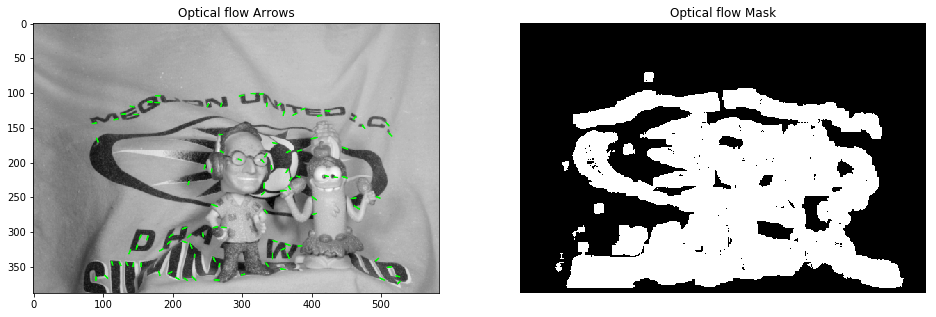

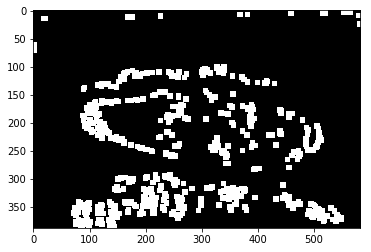

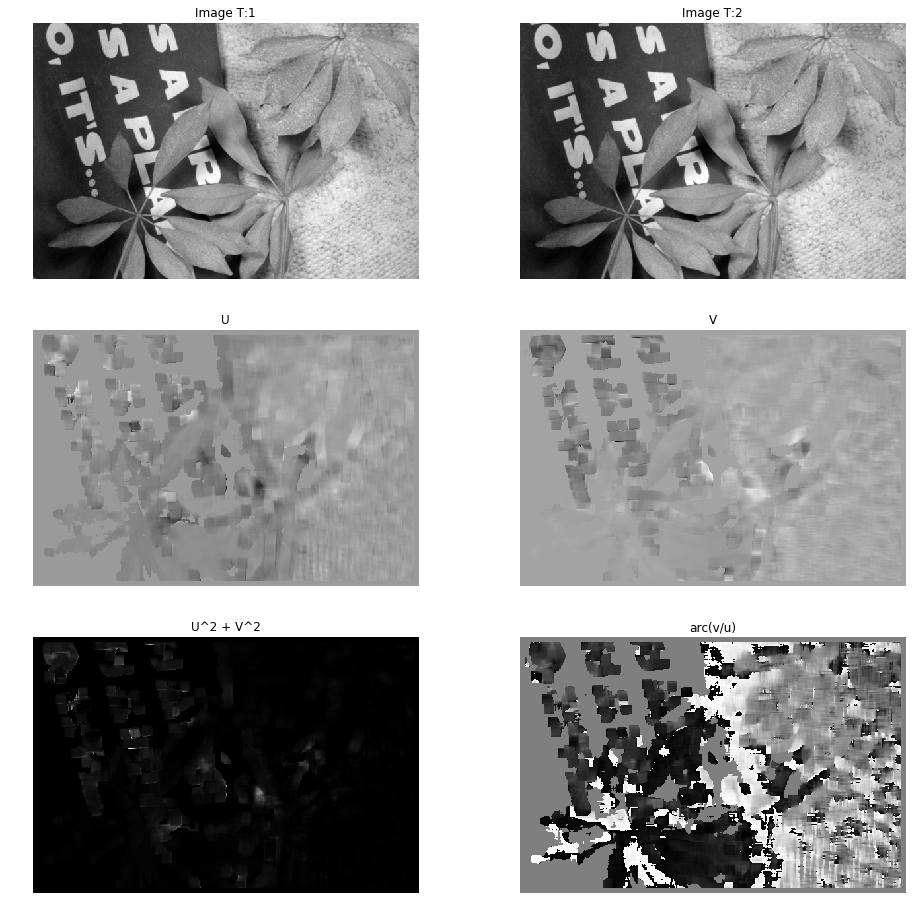

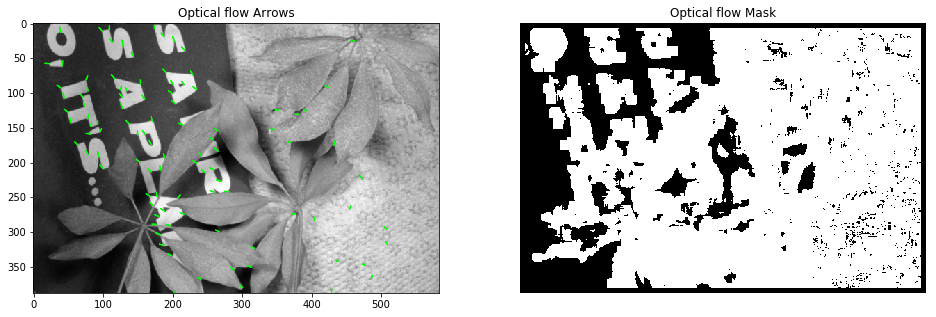

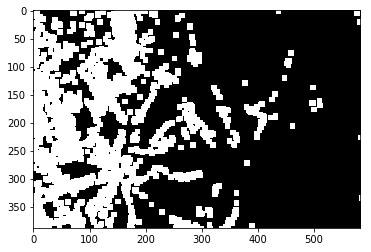

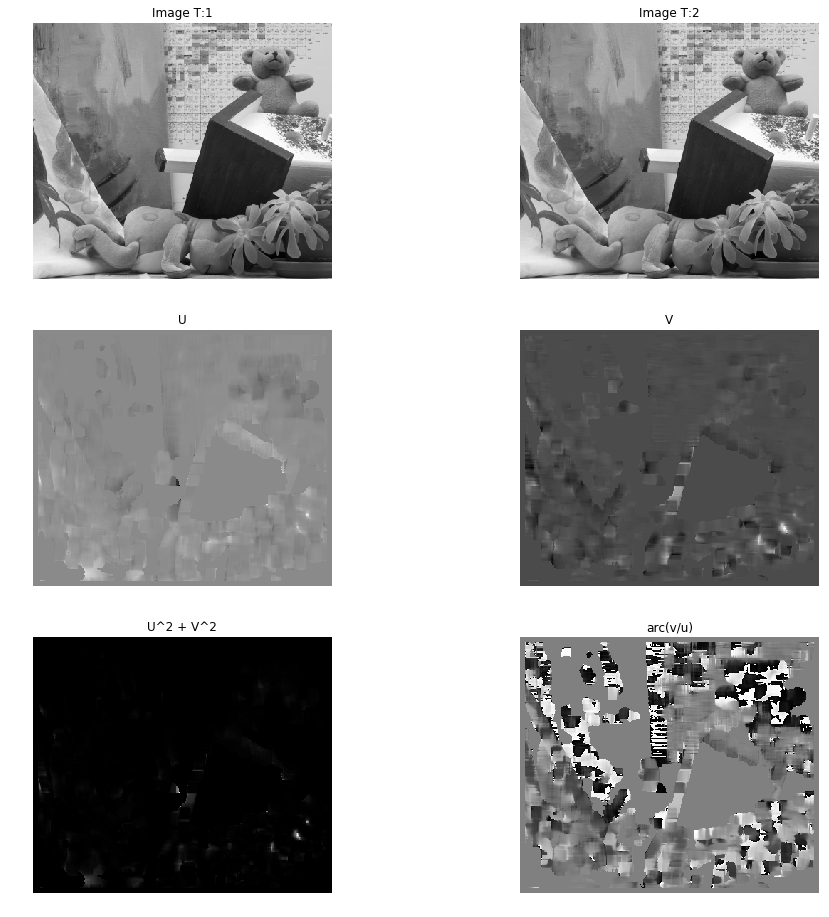

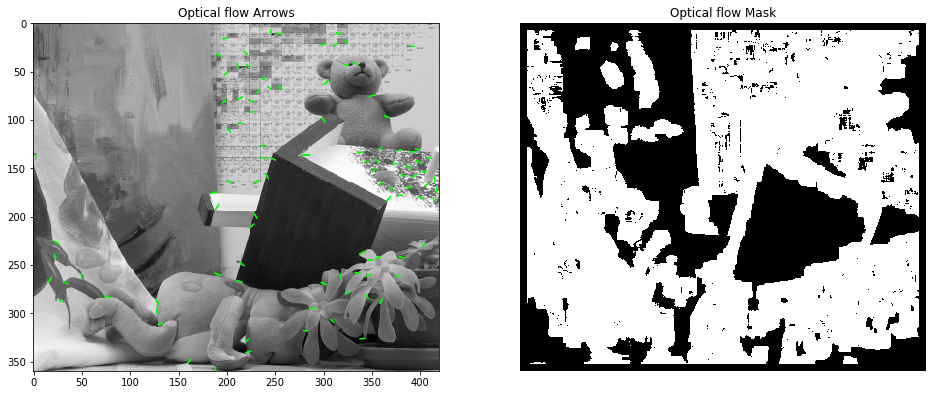

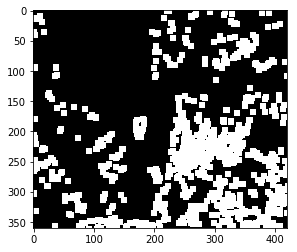

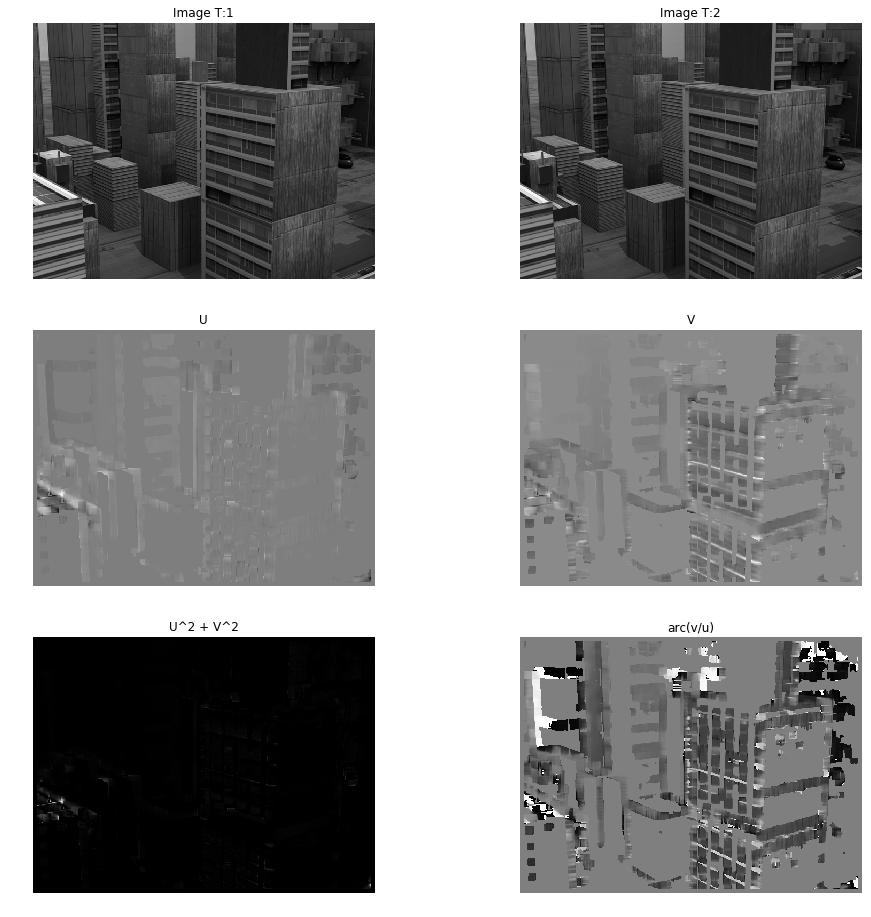

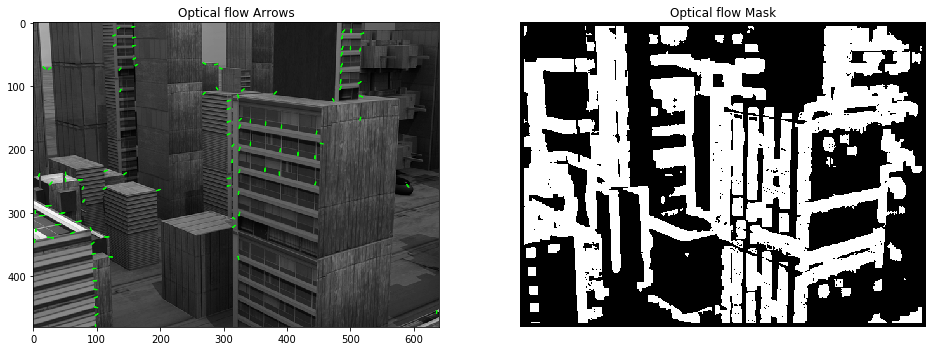

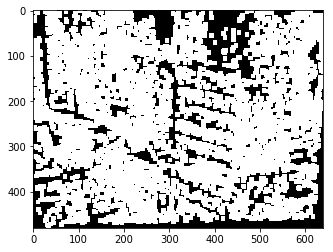

In [ ]:
for image_pair in img_pair_list:
    im1,im2 = image_pair
    u,v = optical_flow(im1,im2,window_size=15)
    display_opticalflow_results(im1,im2,u,v)
    segmentation_as_time(im1,im2,.03,3)